In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt

ee.Initialize()
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')

In [3]:
# Define date range
start_date = ee.Date('2018-01-01')
end_date = start_date.advance(180, 'day')    # 180 days later
sentinel1 = sentinel1.filterDate(start_date, end_date)

In [5]:
# Grab the VH and VV polarized parts in interferometric
# wide swath mode
vh = sentinel1.filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(
    ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(
    ee.Filter.eq('instrumentMode', 'IW'))

In [7]:
# Separate data collected when the sat was ascending and descending
ascending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'));
descending = vh.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'));

In [8]:
# Create a composite from means at different polarizations
# and look angles *for visualization*
composite = ee.Image.cat([
    ascending.select('VH').max(),
    descending.select('VH').max(), 
    ee.ImageCollection(ascending.select('VV').merge(
        descending.select('VV'))).max()]).focal_median(); 

In [44]:
# Construct box to generate data for
centroid = [51.336665, 25.111551]
# geom = ee.Geometry.Rectangle(51.3, 25.1, 51.4, 25.2)
area = ee.Geometry.Polygon([[llx,lly], [llx,ury], [urx,ury], [urx,lly]])
WIDTH = 0.05
HEIGHT = 0.05
llx = centroid[0] - WIDTH / 2
lly = centroid[1] - HEIGHT / 2
urx = centroid[0] + WIDTH / 2
ury = centroid[1] + HEIGHT / 2
geometry = [[llx,lly], [llx,ury], [urx,ury], [urx,lly]]

In [46]:
latlon = ee.Image.pixelLonLat().addBands(composite)
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels=1e8,
  scale=20);

In [47]:
vh = np.array((ee.Array(latlon.get("VH")).getInfo()))
vv = np.array((ee.Array(latlon.get("VV")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

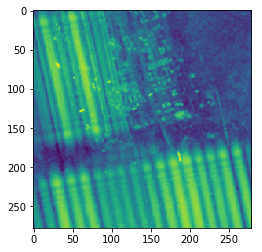

In [55]:
# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
 
# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)
 
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]
 
# create an array with dimensions of image
vh_arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            vh_arr[len(uniqueLats)-1-y,x] = vh[counter] # we start from lower left corner

# Plot VH
plt.imshow(vh_arr)
plt.show()

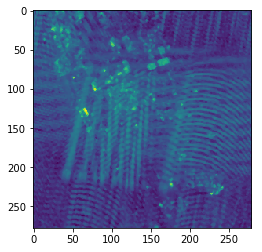

In [57]:
# create an array with dimensions of image
vv_arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            vv_arr[len(uniqueLats)-1-y,x] = vv[counter] # we start from lower left corner

# Plot VV
plt.imshow(vv_arr)
plt.show()